**Import libraries here**

PyTorch, NumPy, Matplotlib, ... Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to initialize the seed for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [19]:
import numpy as np
import os
import torch
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torchvision.transforms.functional as TF

from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import torchvision

from tqdm import tqdm
import torch.optim as optim

import torchvision.transforms as transforms

In [20]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

**Load Dataset**

Use the pickle file shared for this assignment here.

In [21]:
# load the data set
from google.colab import drive

#drive already mounted
drive.mount('/content/drive') 

DATA_PATH = "/content/drive/MyDrive/cs231n/assignments/assignment4/train_carvana.pkl"


with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

X = data['X']
y = data['y']

# Split into X_train, y_train, X_val, y_val
# you can use stratified splitting from sklearn library

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# y = N[np.random.randint(0,80),:,:,:]
# print(y.shape)
# print(N.shape)
print(X.shape)
print(y.shape)
print(type(y))

(80, 1280, 1918, 3)
(80, 1280, 1918)
<class 'numpy.ndarray'>


In the following cell, display one data-point in each line, with three images - the original image, the segmentation mask and the two of them superposed over each other.

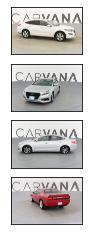

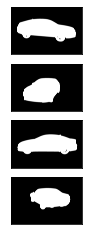

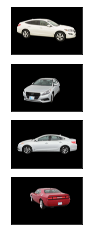

In [23]:
# display 4 datapoints as described above
l = []
for i in range(0,4):
  plt.subplot(4,1,i+1)
  e = np.random.randint(0,80)
  l.append(e)
  i = X[e,:,:,:]
  # m = y[]
  drawing = plt.imshow(i)
  drawing.axes.get_xaxis().set_visible(False)
  drawing.axes.get_yaxis().set_visible(False)
plt.show()

for i in range(0,4):
  plt.subplot(4,1,i+1)
  i = y[l[i],:,:]
  # m = y[]
  drawing = plt.imshow(i, cmap="gray")
  drawing.axes.get_xaxis().set_visible(False)
  drawing.axes.get_yaxis().set_visible(False)
plt.show()

for i in range(0,4):
  plt.subplot(4,1,i+1)
  arrays = [y[l[i],:,:], y[l[i],:,:], y[l[i],:,:]]
  newt = np.stack(arrays, axis=2)
  i = newt * X[l[i],:,:,:]
  # m = y[]
  drawing = plt.imshow(i)
  drawing.axes.get_xaxis().set_visible(False)
  drawing.axes.get_yaxis().set_visible(False)
plt.show()

In [24]:
X_train = X[:50,:,:,:]
y_train = y[:50,:,:]
X_test = X[50:,:,:,:]
y_test = y[50:,:,:]

In [25]:
print(type(y_train))

<class 'numpy.ndarray'>


**Creating a Dataset Class**

Create a Dataset class like in the previous assignment. However, this time you should perform augmentation.

Note - While initializing the dataset class object, make sure you only pass the numpy arrays for images and masks. So the __init__ function should look like

    def __init__(self, X, y):

In [26]:
# define your dataset class
class CarvanaDataset(Dataset):
    def __init__(self, X, y, transform=None):
        X = torch.from_numpy(X)
        X = torch.permute(X, (0, 3, 1, 2))

        y = torch.from_numpy(y)

        self.X = X
        self.y = y
        self.transform = transform

        # self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.X[0])

    def __getitem__(self, index):

        image = self.X[index,:,:,:]
        mask = self.y[index,:,:]
        # assert type(image) != <class 'numpy.ndarray'>

        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


**nn.Module for your model**

Take inspiration from this video - https://www.youtube.com/watch?v=u1loyDCoGbE. Don't just blindly copy the code, you might not need a model as big as the original one.

In [27]:
# define a child class of nn.Module for your model
# specify the architecture here itself
# if necessary, make submodules in different cells for structured code

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(
                feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

**Training loop**

As in the previous assignments, you will write a training loop here. Learning from past experience, do maintain a validation set and monitor loss/accuracy on that to save the best model (instead of having to interrupt execution).

In [28]:
def get_loaders(X_train, y_train, X_test, y_test, batch_size, train_transform, val_transform, num_workers=4):
    train_ds = CarvanaDataset(
        X_train, y_train, transform=train_transform)
    
    train_loader = DataLoader(train_ds, batch_size = batch_size, num_workers = num_workers, shuffle = True)

    val_ds = CarvanaDataset(
        X_test, y_test, transform=val_transform)

    val_loader = DataLoader(val_ds, batch_size = batch_size, num_workers = num_workers, shuffle = False)
    return train_loader, val_loader

def check_accuracy(loader, model, device = "cuda"):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels +=  torch.numel(preds)

    print(
        f"Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f} "
    )
    model.train()

In [29]:
# HYPERPARAMETERS
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1  # 32
NUM_EPOCHS = 3  # 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
# PIN_MEMORY = True
LOAD_MODEL = False

# transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),

# train_transform = transforms.Compose([
#                                       transforms.RandomRotation(35),
#                                       transforms.RandomHorizontalFlip(p=0.5),
#                                       transforms.RandomVerticalFlip(p=0.5),
#                                       transforms.Normalize(
#                                           mean=[0.0, 0.0, 0.0], 
#                                           std=[1.0, 1.0, 1.0], 
#                                           inplace=False)

# ])
# val_transform = transforms.Compose([
#                                       transforms.Normalize(
#                                           mean=[0.0, 0.0, 0.0], 
#                                           std=[1.0, 1.0, 1.0], 
#                                           inplace=False)

# ])


#Facing some compatibility issues here on tranforms, hence have commented them out for now
#Batch size is done at "1", so basically doing stochastic gradient descent as batch gradient descent
#was taking way too much memory

train_transform = None
val_transform = None

model = UNET(in_channels=3,  out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
        X_train,
        y_train,
        X_test,
        y_test,
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS
    )

scaler = torch.cuda.amp.GradScaler()

In [30]:
# def train_fn(model, optimizer, criterion, train_loader, val_loader, display_step=None):
#     pass

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


**Initialize weights**

Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple for loop.

In [31]:
# def init_weights(...):
#     pass

**Prediction & Accuracy**

Prediction function should predict outputs using your trained model for a given NumPy array X_test and the output should be another NumPy array, the mask you predict.

The accuracy function would be the number of pixels you get a correct mask for.

In [32]:
# def predict(model, X_test):
#     pass

In [33]:
# def accuracy(pred, labels):
#     pass

def check_accuracy(loader, model, device = "cuda"):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels +=  torch.numel(preds)

    print(
        f"Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f} "
    )
    model.train()

**Actually training your model**

Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some rand calls above for testing your functions).

Define an instance of the dataset class, wrap it in a dataloader.

Call the train function and train your model!

In [34]:
for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)
    check_accuracy(val_loader, model, device=DEVICE )

100%|██████████| 3/3 [00:04<00:00,  1.42s/it, loss=0.541]


Got 5497168/7365120 with accuracy 74.64 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it, loss=0.48]


Got 5497168/7365120 with accuracy 74.64 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it, loss=0.403]


Got 5497168/7365120 with accuracy 74.64 


This task is not like the usual classification task, you also need to check how the model is doing visually to appreciate the level of learning. Visualize 10 outputs below (as you did in the visualization cell near the top of the notebook).

**Submission**

To submit your solution, you will need to make a file with name model.py containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file dataset.py with the dataset class and all necessary imports. Other than this, save the trained model in a file named ass_4.pt. When you are done with the assignment, commit the updated notebook, the model.py, dataset.py class files and the ass_4.pt model-weights file to the repository.

Note that if you use submodules, all of them should go into the model.py file.

In [35]:
# from google.colab import files
# torch.save(final_model, 'ass_4.pt')
# files.download('ass_4.pt') # download the file from the Colab session for submission

Check if it got saved right!

In [36]:
# load the model, use predict function